In [1]:
# import os
# import tensorflow as tf

# # Set CUDA device order and visible devices
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8,9"

# # Set the device
# device = '/cpu:0'
# if tf.config.experimental.list_physical_devices('GPU'):
#     try:
#         # Restrict TensorFlow to only use the second GPU
#         gpus = tf.config.experimental.list_physical_devices('GPU')
#         if gpus:
#             tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#             device = '/gpu:0'
#     except RuntimeError as e:
#         print(e)

# print("device", device)


In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # Only GPUs 0 and 1 will be visible to TensorFlow

# import tensorflow as tf
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:4"])
# # strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:7"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-09 01:13:50.132595: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-09 01:13:50.148196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 01:13:50.161925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 01:13:50.166082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 01:13:50.179305: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:7',)


2024-10-09 01:13:52.045601: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c9:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='x')  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / 64

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 64, 
                transposed_midpoints_corrected[:, :, 1] * 64, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


Josh's model

In [5]:

# class ModelBuilder:
#     def __init__(self, input_shape=(64, 64, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None):
#         self.input_shape = input_shape
#         self.num_classes = num_classes
#         self.num_coordinates = num_coordinates
#         self.learning_rate = learning_rate
#         self.model = self.build_model()

#         # Load weights if a path is provided
#         if weights_path is not None:
#             self.model.load_weights(weights_path)

#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
#         # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

#     def build_model(self):
        
        
#         x_input = layers.Input(shape=self.input_shape)
        
#         x_1 = layers.Conv2D(64, kernel_size=6,strides =1, padding='same', activation='relu')(x_input)
        
#         x_2 = layers.Conv2D(32, kernel_size=8,strides =3, padding='same', activation='relu')(x_input)
        
#         x_3 = layers.Conv2D(16, kernel_size=19,strides =5, padding='same', activation='relu')(x_input)
        
        
#         x_1 = layers.Flatten()(x_1)
#         x_2 = layers.Flatten()(x_2)
#         x_3 = layers.Flatten()(x_3)
        
#         x = layers.Concatenate()([x_1, x_2, x_3])

#         x = layers.Dense(256, activation='relu')(x)
#         x = layers.Dropout(0.3)(x)
#         x = layers.Dense(128, activation='relu')(x)
#         x = layers.Dense(64, activation='relu')(x)
        
        
#         x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
#         x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
#         return tf.keras.models.Model(x_input, x_midpoints_reshape)

#     def compile_model(self, loss_function):
#         self.model.compile(optimizer=self.optimizer, loss=loss_function)

#     def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
#         history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
#         return history


In [5]:

from tensorflow.keras import layers, regularizers


class ModelBuilder:
    def __init__(self, input_shape=(64, 64, 1), num_classes=13, num_coordinates=2, learning_rate=1e-3, weights_path=None,l1_reg=0.001,l2_reg =0.01):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # self.optimizer =tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)

    
        x_input = layers.Input(shape=self.input_shape)
        
        
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
        
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        
        
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.3)(x)
        # x = layers.BatchNormalization()(x)
        
        x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        # x = layers.BatchNormalization()(x)
        x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
        # x = layers.MaxPool2D()(x)
        # x = layers.Dropout(0.2)(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='linear', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KNoNoiseFixed-index84_13.h5'             

data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


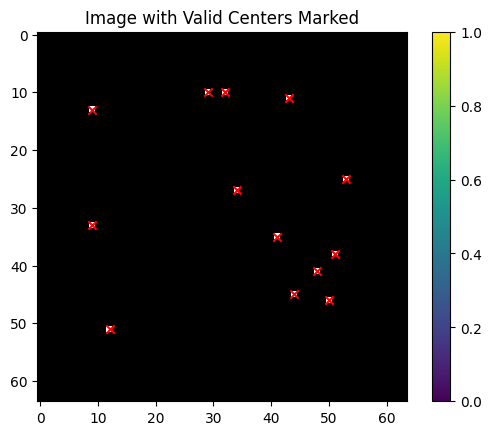

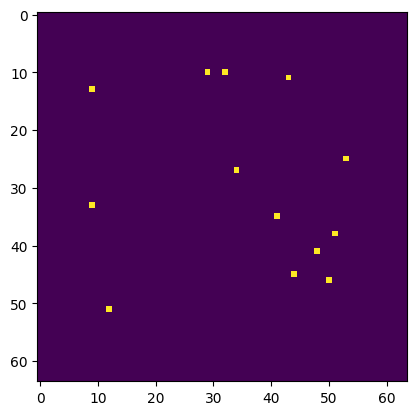

In [24]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l])

In [8]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [9]:

batch_size = 500
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (24000, 64, 64), Train Midpoints: (24000, 1, 13, 2)
Validation Images: (6000, 64, 64), Validation Midpoints: (6000, 1, 13, 2)


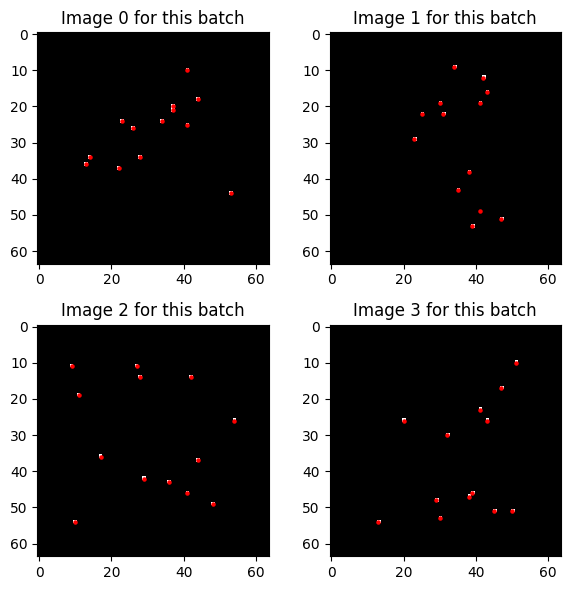

In [10]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [11]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=3e-5
)


In [12]:

# dynamic_exponent_callback = DynamicExponentCallback(1, 1, 50)


with strategy.scope():
    # Instantiate the model builder
    # model_builder = ModelBuilder(weights_path= "/home/da886/Weights from Josh's model/Josh's5fixedMSE45overfit-1.keras")
    model_builder = ModelBuilder()

    # Build the model
    model_builder.build_model()

    # Display the model architecture
    model_builder.model.summary()

    # Compile the model using the custom loss function
    # model_builder.compile_model(loss_function=dynamic_exponent_callback.custom_loss(1))
    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
    





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 2, 128)      │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 26)             │        13,338 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 13, 2)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,059,162 (34.56 MB)

 Trainable params: 9,057,882 (34.55 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [13]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=1100,
    callbacks_list=[lr_scheduler]
)


Epoch 1/1100


2024-10-09 01:14:46.062641: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-09 01:14:50.893711: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1728436490.954365 1288942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436490.989347 1288942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436490.990127 1288942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436490.995326 1288942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436491.006344 1288942 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436491.008780 1288942 gpu_timer.cc

 1/48 ━━━━━━━━━━━━━━━━━━━━ 19:27 25s/step - loss: 0.2996

W0000 00:00:1728436510.675122 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.681796 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.695926 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.696954 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.698090 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.699237 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.700381 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.701360 1288946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436510.702548 1288946 gp

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.4403

2024-10-09 01:15:17.279599: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-09 01:15:17.536121: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1728436517.724424 1288938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436517.725426 1288938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436517.726462 1288938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436517.727660 1288938 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728436517.728919 1288938 gpu_timer.cc:114] Skipping the delay kernel, 

48/48 ━━━━━━━━━━━━━━━━━━━━ 47s 462ms/step - loss: 0.4343 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 2/1100


2024-10-09 01:15:32.468976: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0234 - val_loss: 0.2636 - learning_rate: 0.0010
Epoch 3/1100


2024-10-09 01:15:40.408497: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0190

2024-10-09 01:15:48.534721: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.0190 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 4/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0174 - val_loss: 0.2567 - learning_rate: 0.0010
Epoch 5/1100


2024-10-09 01:15:56.575910: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - loss: 0.0165 - val_loss: 0.2558 - learning_rate: 0.0010
Epoch 6/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0162 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 7/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.0156

2024-10-09 01:16:19.557260: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - loss: 0.0156 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 8/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 0.0152 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 9/1100


2024-10-09 01:16:28.489567: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0149 - val_loss: 0.2260 - learning_rate: 0.0010
Epoch 10/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.0145 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 11/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0143

2024-10-09 01:16:52.799857: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0143 - val_loss: 0.1744 - learning_rate: 0.0010
Epoch 12/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 0.0139 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 13/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0134 - val_loss: 0.1131 - learning_rate: 0.0010
Epoch 14/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0132 - val_loss: 0.0722 - learning_rate: 0.0010
Epoch 15/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0130

2024-10-09 01:17:26.899304: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0130 - val_loss: 0.0508 - learning_rate: 0.0010
Epoch 16/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 0.0127 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 17/1100


2024-10-09 01:17:36.991217: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0125 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 18/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0121 - val_loss: 0.0207 - learning_rate: 0.0010
Epoch 19/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0119

2024-10-09 01:18:00.421878: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - loss: 0.0119 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 20/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0117 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 21/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0113 - val_loss: 0.1743 - learning_rate: 0.0010
Epoch 22/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 0.0111 - val_loss: 0.0141 - learning_rate: 0.0010
Epoch 23/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0110

2024-10-09 01:18:34.126466: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - loss: 0.0110 - val_loss: 0.0226 - learning_rate: 0.0010
Epoch 24/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 0.0107 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 25/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0106 - val_loss: 0.0192 - learning_rate: 0.0010
Epoch 26/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 0.0104 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 27/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.0102

2024-10-09 01:19:08.555110: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0102 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 28/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.0100 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 29/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0098 - val_loss: 0.0261 - learning_rate: 0.0010
Epoch 30/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.0097 - val_loss: 0.0117 - learning_rate: 0.0010
Epoch 31/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0095

2024-10-09 01:19:43.739128: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 0.0095 - val_loss: 0.0160 - learning_rate: 0.0010
Epoch 32/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0093 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 33/1100


2024-10-09 01:19:54.274365: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - loss: 0.0091 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 34/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0089 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 35/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0087

2024-10-09 01:20:18.814975: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - loss: 0.0087 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 36/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0086 - val_loss: 0.0169 - learning_rate: 0.0010
Epoch 37/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0.0083 - val_loss: 0.0129 - learning_rate: 0.0010
Epoch 38/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0082 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 39/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0081

2024-10-09 01:20:53.754098: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - loss: 0.0081 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 40/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0079 - val_loss: 0.0132 - learning_rate: 0.0010
Epoch 41/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0077 - val_loss: 0.0168 - learning_rate: 0.0010
Epoch 42/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0075 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 43/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0072

2024-10-09 01:21:25.828531: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0072 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 44/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0069 - val_loss: 0.0845 - learning_rate: 0.0010
Epoch 45/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0068 - val_loss: 0.0243 - learning_rate: 0.0010
Epoch 46/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0065 - val_loss: 0.0133 - learning_rate: 0.0010
Epoch 47/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0064

2024-10-09 01:21:58.599778: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0064 - val_loss: 0.0156 - learning_rate: 0.0010
Epoch 48/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0061 - val_loss: 0.0120 - learning_rate: 0.0010
Epoch 49/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0059 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 50/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0055 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 51/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0053

2024-10-09 01:22:29.931600: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 0.0053 - val_loss: 0.0174 - learning_rate: 0.0010
Epoch 52/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0050 - val_loss: 0.0142 - learning_rate: 0.0010
Epoch 53/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0047
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0047 - val_loss: 0.0162 - learning_rate: 0.0010
Epoch 54/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - loss: 0.0043 - val_loss: 0.0158 - learning_rate: 9.0000e-04
Epoch 55/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0039

2024-10-09 01:23:03.503807: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0039 - val_loss: 0.0250 - learning_rate: 9.0000e-04
Epoch 56/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 0.0036 - val_loss: 0.0128 - learning_rate: 9.0000e-04
Epoch 57/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0033 - val_loss: 0.0136 - learning_rate: 9.0000e-04
Epoch 58/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0031 - val_loss: 0.0162 - learning_rate: 9.0000e-04
Epoch 59/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0029

2024-10-09 01:23:38.732517: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0029 - val_loss: 0.0143 - learning_rate: 9.0000e-04
Epoch 60/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 0.0027 - val_loss: 0.0154 - learning_rate: 9.0000e-04
Epoch 61/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0023 - val_loss: 0.0132 - learning_rate: 9.0000e-04
Epoch 62/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0022 - val_loss: 0.0157 - learning_rate: 9.0000e-04
Epoch 63/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0021

2024-10-09 01:24:11.701664: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 0.0021 - val_loss: 0.0126 - learning_rate: 9.0000e-04
Epoch 64/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0018 - val_loss: 0.0155 - learning_rate: 8.1000e-04
Epoch 65/1100


2024-10-09 01:24:20.040969: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 0.0017 - val_loss: 0.0130 - learning_rate: 8.1000e-04
Epoch 66/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0016 - val_loss: 0.0126 - learning_rate: 8.1000e-04
Epoch 67/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0014

2024-10-09 01:24:43.529725: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0014 - val_loss: 0.0139 - learning_rate: 8.1000e-04
Epoch 68/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 0.0013 - val_loss: 0.0171 - learning_rate: 8.1000e-04
Epoch 69/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 0.0013 - val_loss: 0.0130 - learning_rate: 8.1000e-04
Epoch 70/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 0.0013 - val_loss: 0.0159 - learning_rate: 8.1000e-04
Epoch 71/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0012

2024-10-09 01:25:17.262938: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0012 - val_loss: 0.0135 - learning_rate: 8.1000e-04
Epoch 72/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0011 - val_loss: 0.0126 - learning_rate: 8.1000e-04
Epoch 73/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0011
Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 0.0011 - val_loss: 0.0132 - learning_rate: 8.1000e-04
Epoch 74/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.0011 - val_loss: 0.0132 - learning_rate: 7.2900e-04
Epoch 75/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.0010

2024-10-09 01:25:49.641333: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 0.0010 - val_loss: 0.0134 - learning_rate: 7.2900e-04
Epoch 76/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 0.0010 - val_loss: 0.0135 - learning_rate: 7.2900e-04
Epoch 77/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 9.2467e-04 - val_loss: 0.0132 - learning_rate: 7.2900e-04
Epoch 78/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 9.0826e-04 - val_loss: 0.0156 - learning_rate: 7.2900e-04
Epoch 79/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 8.9609e-04

2024-10-09 01:26:23.764198: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 8.9669e-04 - val_loss: 0.0130 - learning_rate: 7.2900e-04
Epoch 80/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 9.4782e-04 - val_loss: 0.0132 - learning_rate: 7.2900e-04
Epoch 81/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 8.9385e-04 - val_loss: 0.0132 - learning_rate: 7.2900e-04
Epoch 82/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 9.1581e-04 - val_loss: 0.0132 - learning_rate: 7.2900e-04
Epoch 83/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 9.1621e-04

2024-10-09 01:26:58.236522: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 83: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 9.1615e-04 - val_loss: 0.0125 - learning_rate: 7.2900e-04
Epoch 84/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.2388e-04 - val_loss: 0.0129 - learning_rate: 6.5610e-04
Epoch 85/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 7.6027e-04 - val_loss: 0.0128 - learning_rate: 6.5610e-04
Epoch 86/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 7.6192e-04 - val_loss: 0.0130 - learning_rate: 6.5610e-04
Epoch 87/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.8023e-04

2024-10-09 01:27:30.318127: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 7.8016e-04 - val_loss: 0.0132 - learning_rate: 6.5610e-04
Epoch 88/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 8.1680e-04 - val_loss: 0.0148 - learning_rate: 6.5610e-04
Epoch 89/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.6898e-04 - val_loss: 0.0143 - learning_rate: 6.5610e-04
Epoch 90/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 7.4535e-04 - val_loss: 0.0129 - learning_rate: 6.5610e-04
Epoch 91/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.5769e-04

2024-10-09 01:28:02.397627: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 7.5777e-04 - val_loss: 0.0137 - learning_rate: 6.5610e-04
Epoch 92/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.4740e-04 - val_loss: 0.0128 - learning_rate: 6.5610e-04
Epoch 93/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.5289e-04
Epoch 93: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.5288e-04 - val_loss: 0.0129 - learning_rate: 6.5610e-04
Epoch 94/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 7.0434e-04 - val_loss: 0.0132 - learning_rate: 5.9049e-04
Epoch 95/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.5285e-04

2024-10-09 01:28:35.665691: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.5285e-04 - val_loss: 0.0139 - learning_rate: 5.9049e-04
Epoch 96/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 5.9583e-04 - val_loss: 0.0133 - learning_rate: 5.9049e-04
Epoch 97/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 6.0125e-04 - val_loss: 0.0127 - learning_rate: 5.9049e-04
Epoch 98/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 6.3597e-04 - val_loss: 0.0126 - learning_rate: 5.9049e-04
Epoch 99/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.3940e-04

2024-10-09 01:29:09.966696: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 6.3936e-04 - val_loss: 0.0122 - learning_rate: 5.9049e-04
Epoch 100/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.2251e-04 - val_loss: 0.0132 - learning_rate: 5.9049e-04
Epoch 101/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 5.7804e-04 - val_loss: 0.0128 - learning_rate: 5.9049e-04
Epoch 102/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.1312e-04 - val_loss: 0.0123 - learning_rate: 5.9049e-04
Epoch 103/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 6.1048e-04

2024-10-09 01:29:44.140815: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 103: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 6.1037e-04 - val_loss: 0.0137 - learning_rate: 5.9049e-04
Epoch 104/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.6484e-04 - val_loss: 0.0144 - learning_rate: 5.3144e-04
Epoch 105/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 5.5324e-04 - val_loss: 0.0125 - learning_rate: 5.3144e-04
Epoch 106/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 5.2343e-04 - val_loss: 0.0129 - learning_rate: 5.3144e-04
Epoch 107/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.0334e-04

2024-10-09 01:30:16.001288: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0340e-04 - val_loss: 0.0124 - learning_rate: 5.3144e-04
Epoch 108/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 5.2550e-04 - val_loss: 0.0123 - learning_rate: 5.3144e-04
Epoch 109/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 5.3330e-04 - val_loss: 0.0127 - learning_rate: 5.3144e-04
Epoch 110/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 5.1361e-04 - val_loss: 0.0127 - learning_rate: 5.3144e-04
Epoch 111/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 5.3184e-04

2024-10-09 01:30:48.896258: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 5.3186e-04 - val_loss: 0.0126 - learning_rate: 5.3144e-04
Epoch 112/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 5.3293e-04 - val_loss: 0.0122 - learning_rate: 5.3144e-04
Epoch 113/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 5.2320e-04
Epoch 113: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 5.2355e-04 - val_loss: 0.0135 - learning_rate: 5.3144e-04
Epoch 114/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.4088e-04 - val_loss: 0.0124 - learning_rate: 4.7830e-04
Epoch 115/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.0441e-04

2024-10-09 01:31:23.824189: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 5.0430e-04 - val_loss: 0.0123 - learning_rate: 4.7830e-04
Epoch 116/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.8161e-04 - val_loss: 0.0128 - learning_rate: 4.7830e-04
Epoch 117/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 5.0853e-04 - val_loss: 0.0124 - learning_rate: 4.7830e-04
Epoch 118/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.3110e-04 - val_loss: 0.0132 - learning_rate: 4.7830e-04
Epoch 119/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.1767e-04

2024-10-09 01:31:57.355493: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.1748e-04 - val_loss: 0.0121 - learning_rate: 4.7830e-04
Epoch 120/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 4.7641e-04 - val_loss: 0.0122 - learning_rate: 4.7830e-04
Epoch 121/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 5.0285e-04 - val_loss: 0.0123 - learning_rate: 4.7830e-04
Epoch 122/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2031e-04 - val_loss: 0.0120 - learning_rate: 4.7830e-04
Epoch 123/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.2503e-04

2024-10-09 01:32:29.719295: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 123: ReduceLROnPlateau reducing learning rate to 0.0004304672533180565.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2493e-04 - val_loss: 0.0127 - learning_rate: 4.7830e-04
Epoch 124/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 4.8560e-04 - val_loss: 0.0125 - learning_rate: 4.3047e-04
Epoch 125/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.3782e-04 - val_loss: 0.0132 - learning_rate: 4.3047e-04
Epoch 126/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.3692e-04 - val_loss: 0.0121 - learning_rate: 4.3047e-04
Epoch 127/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.0317e-04

2024-10-09 01:33:02.469582: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 4.0312e-04 - val_loss: 0.0132 - learning_rate: 4.3047e-04
Epoch 128/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.2490e-04 - val_loss: 0.0125 - learning_rate: 4.3047e-04
Epoch 129/1100


2024-10-09 01:33:11.466329: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.2602e-04 - val_loss: 0.0127 - learning_rate: 4.3047e-04
Epoch 130/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.0947e-04 - val_loss: 0.0124 - learning_rate: 4.3047e-04
Epoch 131/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 4.4874e-04

2024-10-09 01:33:35.381863: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.4866e-04 - val_loss: 0.0129 - learning_rate: 4.3047e-04
Epoch 132/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.6398e-04 - val_loss: 0.0127 - learning_rate: 4.3047e-04
Epoch 133/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4795e-04
Epoch 133: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.4819e-04 - val_loss: 0.0131 - learning_rate: 4.3047e-04
Epoch 134/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.4036e-04 - val_loss: 0.0124 - learning_rate: 3.8742e-04
Epoch 135/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.1098e-04

2024-10-09 01:34:07.472787: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.1100e-04 - val_loss: 0.0119 - learning_rate: 3.8742e-04
Epoch 136/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.1367e-04 - val_loss: 0.0123 - learning_rate: 3.8742e-04
Epoch 137/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 3.8859e-04 - val_loss: 0.0126 - learning_rate: 3.8742e-04
Epoch 138/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8624e-04 - val_loss: 0.0119 - learning_rate: 3.8742e-04
Epoch 139/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.9234e-04

2024-10-09 01:34:38.898889: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9264e-04 - val_loss: 0.0122 - learning_rate: 3.8742e-04
Epoch 140/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 3.9705e-04 - val_loss: 0.0129 - learning_rate: 3.8742e-04
Epoch 141/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9395e-04 - val_loss: 0.0122 - learning_rate: 3.8742e-04
Epoch 142/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.1702e-04 - val_loss: 0.0122 - learning_rate: 3.8742e-04
Epoch 143/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.9845e-04

2024-10-09 01:35:12.682910: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 143: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9858e-04 - val_loss: 0.0124 - learning_rate: 3.8742e-04
Epoch 144/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.3225e-04 - val_loss: 0.0121 - learning_rate: 3.4868e-04
Epoch 145/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.7130e-04 - val_loss: 0.0132 - learning_rate: 3.4868e-04
Epoch 146/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8377e-04 - val_loss: 0.0125 - learning_rate: 3.4868e-04
Epoch 147/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.7341e-04

2024-10-09 01:35:44.377870: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.7330e-04 - val_loss: 0.0132 - learning_rate: 3.4868e-04
Epoch 148/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5807e-04 - val_loss: 0.0120 - learning_rate: 3.4868e-04
Epoch 149/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.3210e-04 - val_loss: 0.0124 - learning_rate: 3.4868e-04
Epoch 150/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3496e-04 - val_loss: 0.0123 - learning_rate: 3.4868e-04
Epoch 151/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5112e-04

2024-10-09 01:36:16.841971: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.5134e-04 - val_loss: 0.0118 - learning_rate: 3.4868e-04
Epoch 152/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.6364e-04 - val_loss: 0.0130 - learning_rate: 3.4868e-04
Epoch 153/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.1665e-04
Epoch 153: ReduceLROnPlateau reducing learning rate to 0.00031381062290165574.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 4.1688e-04 - val_loss: 0.0142 - learning_rate: 3.4868e-04
Epoch 154/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.0073e-04 - val_loss: 0.0124 - learning_rate: 3.1381e-04
Epoch 155/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4501e-04

2024-10-09 01:36:51.140532: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.4492e-04 - val_loss: 0.0118 - learning_rate: 3.1381e-04
Epoch 156/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.1498e-04 - val_loss: 0.0119 - learning_rate: 3.1381e-04
Epoch 157/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 2.9955e-04 - val_loss: 0.0120 - learning_rate: 3.1381e-04
Epoch 158/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2676e-04 - val_loss: 0.0119 - learning_rate: 3.1381e-04
Epoch 159/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2088e-04

2024-10-09 01:37:24.127662: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2094e-04 - val_loss: 0.0121 - learning_rate: 3.1381e-04
Epoch 160/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.2429e-04 - val_loss: 0.0118 - learning_rate: 3.1381e-04
Epoch 161/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.7059e-04 - val_loss: 0.0123 - learning_rate: 3.1381e-04
Epoch 162/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - loss: 3.3215e-04 - val_loss: 0.0116 - learning_rate: 3.1381e-04
Epoch 163/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1933e-04

2024-10-09 01:37:56.743844: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 163: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1940e-04 - val_loss: 0.0120 - learning_rate: 3.1381e-04
Epoch 164/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 3.0748e-04 - val_loss: 0.0120 - learning_rate: 2.8243e-04
Epoch 165/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9255e-04 - val_loss: 0.0119 - learning_rate: 2.8243e-04
Epoch 166/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.8034e-04 - val_loss: 0.0119 - learning_rate: 2.8243e-04
Epoch 167/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9611e-04

2024-10-09 01:38:29.993155: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9613e-04 - val_loss: 0.0119 - learning_rate: 2.8243e-04
Epoch 168/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.9395e-04 - val_loss: 0.0119 - learning_rate: 2.8243e-04
Epoch 169/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9431e-04 - val_loss: 0.0122 - learning_rate: 2.8243e-04
Epoch 170/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 2.9260e-04 - val_loss: 0.0118 - learning_rate: 2.8243e-04
Epoch 171/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.0634e-04

2024-10-09 01:39:05.148295: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0625e-04 - val_loss: 0.0119 - learning_rate: 2.8243e-04
Epoch 172/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.0114e-04 - val_loss: 0.0118 - learning_rate: 2.8243e-04
Epoch 173/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7022e-04
Epoch 173: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7060e-04 - val_loss: 0.0118 - learning_rate: 2.8243e-04
Epoch 174/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7721e-04 - val_loss: 0.0120 - learning_rate: 2.5419e-04
Epoch 175/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6802e-04

2024-10-09 01:39:37.159065: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.6820e-04 - val_loss: 0.0123 - learning_rate: 2.5419e-04
Epoch 176/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7136e-04 - val_loss: 0.0117 - learning_rate: 2.5419e-04
Epoch 177/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6798e-04 - val_loss: 0.0120 - learning_rate: 2.5419e-04
Epoch 178/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6162e-04 - val_loss: 0.0121 - learning_rate: 2.5419e-04
Epoch 179/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5423e-04

2024-10-09 01:40:08.627444: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5425e-04 - val_loss: 0.0121 - learning_rate: 2.5419e-04
Epoch 180/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 2.5444e-04 - val_loss: 0.0119 - learning_rate: 2.5419e-04
Epoch 181/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5851e-04 - val_loss: 0.0129 - learning_rate: 2.5419e-04
Epoch 182/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5994e-04 - val_loss: 0.0122 - learning_rate: 2.5419e-04
Epoch 183/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7354e-04

2024-10-09 01:40:41.937552: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 183: ReduceLROnPlateau reducing learning rate to 0.00022876793809700757.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7359e-04 - val_loss: 0.0118 - learning_rate: 2.5419e-04
Epoch 184/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.6018e-04 - val_loss: 0.0119 - learning_rate: 2.2877e-04
Epoch 185/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.4768e-04 - val_loss: 0.0118 - learning_rate: 2.2877e-04
Epoch 186/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.3531e-04 - val_loss: 0.0119 - learning_rate: 2.2877e-04
Epoch 187/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2869e-04

2024-10-09 01:41:14.390005: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 2.2877e-04 - val_loss: 0.0121 - learning_rate: 2.2877e-04
Epoch 188/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.4126e-04 - val_loss: 0.0123 - learning_rate: 2.2877e-04
Epoch 189/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3475e-04 - val_loss: 0.0120 - learning_rate: 2.2877e-04
Epoch 190/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.4042e-04 - val_loss: 0.0120 - learning_rate: 2.2877e-04
Epoch 191/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7055e-04

2024-10-09 01:41:46.307092: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.7036e-04 - val_loss: 0.0125 - learning_rate: 2.2877e-04
Epoch 192/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5293e-04 - val_loss: 0.0118 - learning_rate: 2.2877e-04
Epoch 193/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.5284e-04
Epoch 193: ReduceLROnPlateau reducing learning rate to 0.00020589114428730683.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.5275e-04 - val_loss: 0.0123 - learning_rate: 2.2877e-04
Epoch 194/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2924e-04 - val_loss: 0.0119 - learning_rate: 2.0589e-04
Epoch 195/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4146e-04

2024-10-09 01:42:17.903412: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.4162e-04 - val_loss: 0.0122 - learning_rate: 2.0589e-04
Epoch 196/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.3895e-04 - val_loss: 0.0117 - learning_rate: 2.0589e-04
Epoch 197/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 2.2620e-04 - val_loss: 0.0121 - learning_rate: 2.0589e-04
Epoch 198/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.5125e-04 - val_loss: 0.0117 - learning_rate: 2.0589e-04
Epoch 199/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2196e-04

2024-10-09 01:42:51.345518: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2190e-04 - val_loss: 0.0122 - learning_rate: 2.0589e-04
Epoch 200/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.1857e-04 - val_loss: 0.0117 - learning_rate: 2.0589e-04
Epoch 201/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3405e-04 - val_loss: 0.0115 - learning_rate: 2.0589e-04
Epoch 202/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 2.3658e-04 - val_loss: 0.0117 - learning_rate: 2.0589e-04
Epoch 203/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.2403e-04

2024-10-09 01:43:23.240239: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 203: ReduceLROnPlateau reducing learning rate to 0.00018530203378759326.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.2408e-04 - val_loss: 0.0118 - learning_rate: 2.0589e-04
Epoch 204/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.0292e-04 - val_loss: 0.0118 - learning_rate: 1.8530e-04
Epoch 205/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 1.8901e-04 - val_loss: 0.0121 - learning_rate: 1.8530e-04
Epoch 206/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.9201e-04 - val_loss: 0.0121 - learning_rate: 1.8530e-04
Epoch 207/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.8750e-04

2024-10-09 01:43:55.171565: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 1.8756e-04 - val_loss: 0.0118 - learning_rate: 1.8530e-04
Epoch 208/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.9134e-04 - val_loss: 0.0120 - learning_rate: 1.8530e-04
Epoch 209/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 1.9915e-04 - val_loss: 0.0118 - learning_rate: 1.8530e-04
Epoch 210/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.0654e-04 - val_loss: 0.0120 - learning_rate: 1.8530e-04
Epoch 211/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.9684e-04

2024-10-09 01:44:27.636743: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 1.9696e-04 - val_loss: 0.0119 - learning_rate: 1.8530e-04
Epoch 212/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.1737e-04 - val_loss: 0.0118 - learning_rate: 1.8530e-04
Epoch 213/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2061e-04
Epoch 213: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - loss: 2.2047e-04 - val_loss: 0.0119 - learning_rate: 1.8530e-04
Epoch 214/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.9047e-04 - val_loss: 0.0120 - learning_rate: 1.6677e-04
Epoch 215/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.8697e-04

2024-10-09 01:45:03.192108: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.8692e-04 - val_loss: 0.0118 - learning_rate: 1.6677e-04
Epoch 216/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 1.6374e-04 - val_loss: 0.0118 - learning_rate: 1.6677e-04
Epoch 217/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.7398e-04 - val_loss: 0.0120 - learning_rate: 1.6677e-04
Epoch 218/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 1.6455e-04 - val_loss: 0.0124 - learning_rate: 1.6677e-04
Epoch 219/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.7196e-04

2024-10-09 01:45:35.761422: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.7200e-04 - val_loss: 0.0119 - learning_rate: 1.6677e-04
Epoch 220/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.7836e-04 - val_loss: 0.0123 - learning_rate: 1.6677e-04
Epoch 221/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.8931e-04 - val_loss: 0.0119 - learning_rate: 1.6677e-04
Epoch 222/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.8420e-04 - val_loss: 0.0118 - learning_rate: 1.6677e-04
Epoch 223/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.8514e-04

2024-10-09 01:46:06.745267: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 223: ReduceLROnPlateau reducing learning rate to 0.00015009464841568844.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 1.8507e-04 - val_loss: 0.0118 - learning_rate: 1.6677e-04
Epoch 224/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.8133e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 225/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 1.6145e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 226/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 1.6048e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 227/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.6611e-04

2024-10-09 01:46:42.459377: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 1.6609e-04 - val_loss: 0.0118 - learning_rate: 1.5009e-04
Epoch 228/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.5490e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 229/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 1.5881e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 230/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - loss: 1.7146e-04 - val_loss: 0.0117 - learning_rate: 1.5009e-04
Epoch 231/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.4868e-04

2024-10-09 01:47:18.724900: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.4874e-04 - val_loss: 0.0118 - learning_rate: 1.5009e-04
Epoch 232/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 1.5570e-04 - val_loss: 0.0117 - learning_rate: 1.5009e-04
Epoch 233/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.6110e-04
Epoch 233: ReduceLROnPlateau reducing learning rate to 0.0001350851875031367.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.6117e-04 - val_loss: 0.0119 - learning_rate: 1.5009e-04
Epoch 234/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 1.6613e-04 - val_loss: 0.0119 - learning_rate: 1.3509e-04
Epoch 235/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.4553e-04

2024-10-09 01:47:53.901807: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 1.4559e-04 - val_loss: 0.0117 - learning_rate: 1.3509e-04
Epoch 236/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 1.5231e-04 - val_loss: 0.0121 - learning_rate: 1.3509e-04
Epoch 237/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.5114e-04 - val_loss: 0.0118 - learning_rate: 1.3509e-04
Epoch 238/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.4534e-04 - val_loss: 0.0119 - learning_rate: 1.3509e-04
Epoch 239/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.5606e-04

2024-10-09 01:48:27.246998: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 1.5609e-04 - val_loss: 0.0119 - learning_rate: 1.3509e-04
Epoch 240/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.6147e-04 - val_loss: 0.0118 - learning_rate: 1.3509e-04
Epoch 241/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 1.5528e-04 - val_loss: 0.0122 - learning_rate: 1.3509e-04
Epoch 242/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 1.4882e-04 - val_loss: 0.0118 - learning_rate: 1.3509e-04
Epoch 243/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.4584e-04

2024-10-09 01:48:59.488034: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 243: ReduceLROnPlateau reducing learning rate to 0.00012157666351413355.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 1.4581e-04 - val_loss: 0.0118 - learning_rate: 1.3509e-04
Epoch 244/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.4076e-04 - val_loss: 0.0117 - learning_rate: 1.2158e-04
Epoch 245/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - loss: 1.4187e-04 - val_loss: 0.0117 - learning_rate: 1.2158e-04
Epoch 246/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.3538e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 247/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.3224e-04

2024-10-09 01:49:33.931104: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - loss: 1.3233e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 248/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 1.4537e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 249/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 1.4169e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 250/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.4308e-04 - val_loss: 0.0117 - learning_rate: 1.2158e-04
Epoch 251/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.3128e-04

2024-10-09 01:50:07.284056: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.3129e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 252/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 1.2857e-04 - val_loss: 0.0118 - learning_rate: 1.2158e-04
Epoch 253/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 1.3132e-04
Epoch 253: ReduceLROnPlateau reducing learning rate to 0.00010941899454337544.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.3144e-04 - val_loss: 0.0119 - learning_rate: 1.2158e-04
Epoch 254/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.3911e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 255/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.2383e-04

2024-10-09 01:50:39.345392: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 1.2382e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 256/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.2483e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 257/1100


2024-10-09 01:50:47.637994: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 1.2918e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 258/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 1.2228e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 259/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.2555e-04

2024-10-09 01:51:10.757321: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 1.2561e-04 - val_loss: 0.0119 - learning_rate: 1.0942e-04
Epoch 260/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.2240e-04 - val_loss: 0.0122 - learning_rate: 1.0942e-04
Epoch 261/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.2057e-04 - val_loss: 0.0119 - learning_rate: 1.0942e-04
Epoch 262/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.2495e-04 - val_loss: 0.0119 - learning_rate: 1.0942e-04
Epoch 263/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.2272e-04

2024-10-09 01:51:44.150370: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 263: ReduceLROnPlateau reducing learning rate to 9.847709443420172e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 1.2277e-04 - val_loss: 0.0118 - learning_rate: 1.0942e-04
Epoch 264/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 1.1978e-04 - val_loss: 0.0120 - learning_rate: 9.8477e-05
Epoch 265/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.1890e-04 - val_loss: 0.0120 - learning_rate: 9.8477e-05
Epoch 266/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 1.1574e-04 - val_loss: 0.0120 - learning_rate: 9.8477e-05
Epoch 267/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.2658e-04

2024-10-09 01:52:17.539513: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.2664e-04 - val_loss: 0.0119 - learning_rate: 9.8477e-05
Epoch 268/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 1.1974e-04 - val_loss: 0.0117 - learning_rate: 9.8477e-05
Epoch 269/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.1622e-04 - val_loss: 0.0119 - learning_rate: 9.8477e-05
Epoch 270/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - loss: 1.3262e-04 - val_loss: 0.0118 - learning_rate: 9.8477e-05
Epoch 271/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.1437e-04

2024-10-09 01:52:52.134521: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.1439e-04 - val_loss: 0.0118 - learning_rate: 9.8477e-05
Epoch 272/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 1.1040e-04 - val_loss: 0.0119 - learning_rate: 9.8477e-05
Epoch 273/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.2367e-04
Epoch 273: ReduceLROnPlateau reducing learning rate to 8.862938630045391e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.2366e-04 - val_loss: 0.0118 - learning_rate: 9.8477e-05
Epoch 274/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 1.0880e-04 - val_loss: 0.0121 - learning_rate: 8.8629e-05
Epoch 275/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 1.1442e-04

2024-10-09 01:53:26.875284: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.1439e-04 - val_loss: 0.0117 - learning_rate: 8.8629e-05
Epoch 276/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.0382e-04 - val_loss: 0.0118 - learning_rate: 8.8629e-05
Epoch 277/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 1.0071e-04 - val_loss: 0.0119 - learning_rate: 8.8629e-05
Epoch 278/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.0807e-04 - val_loss: 0.0118 - learning_rate: 8.8629e-05
Epoch 279/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.0059e-04

2024-10-09 01:53:58.668684: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 1.0061e-04 - val_loss: 0.0119 - learning_rate: 8.8629e-05
Epoch 280/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.0456e-04 - val_loss: 0.0118 - learning_rate: 8.8629e-05
Epoch 281/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.0170e-04 - val_loss: 0.0119 - learning_rate: 8.8629e-05
Epoch 282/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 1.0231e-04 - val_loss: 0.0118 - learning_rate: 8.8629e-05
Epoch 283/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 9.9720e-05

2024-10-09 01:54:30.373206: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 283: ReduceLROnPlateau reducing learning rate to 7.976644701557234e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 9.9760e-05 - val_loss: 0.0119 - learning_rate: 8.8629e-05
Epoch 284/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 1.0422e-04 - val_loss: 0.0119 - learning_rate: 7.9766e-05
Epoch 285/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - loss: 9.8779e-05 - val_loss: 0.0121 - learning_rate: 7.9766e-05
Epoch 286/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 9.4522e-05 - val_loss: 0.0119 - learning_rate: 7.9766e-05
Epoch 287/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 9.9256e-05

2024-10-09 01:55:07.611038: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 9.9324e-05 - val_loss: 0.0119 - learning_rate: 7.9766e-05
Epoch 288/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 9.8685e-05 - val_loss: 0.0119 - learning_rate: 7.9766e-05
Epoch 289/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 9.8941e-05 - val_loss: 0.0122 - learning_rate: 7.9766e-05
Epoch 290/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 1.0807e-04 - val_loss: 0.0120 - learning_rate: 7.9766e-05
Epoch 291/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 1.0654e-04

2024-10-09 01:55:40.407128: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 1.0656e-04 - val_loss: 0.0118 - learning_rate: 7.9766e-05
Epoch 292/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 9.7494e-05 - val_loss: 0.0121 - learning_rate: 7.9766e-05
Epoch 293/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 9.7004e-05
Epoch 293: ReduceLROnPlateau reducing learning rate to 7.178980231401511e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 9.6987e-05 - val_loss: 0.0117 - learning_rate: 7.9766e-05
Epoch 294/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 9.0087e-05 - val_loss: 0.0118 - learning_rate: 7.1790e-05
Epoch 295/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 8.9599e-05

2024-10-09 01:56:12.710326: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.9666e-05 - val_loss: 0.0119 - learning_rate: 7.1790e-05
Epoch 296/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - loss: 9.0171e-05 - val_loss: 0.0119 - learning_rate: 7.1790e-05
Epoch 297/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 9.1904e-05 - val_loss: 0.0121 - learning_rate: 7.1790e-05
Epoch 298/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 9.0491e-05 - val_loss: 0.0118 - learning_rate: 7.1790e-05
Epoch 299/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 8.4754e-05

2024-10-09 01:56:46.511663: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 8.4802e-05 - val_loss: 0.0120 - learning_rate: 7.1790e-05
Epoch 300/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 8.6496e-05 - val_loss: 0.0119 - learning_rate: 7.1790e-05
Epoch 301/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 9.2004e-05 - val_loss: 0.0119 - learning_rate: 7.1790e-05
Epoch 302/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 8.8169e-05 - val_loss: 0.0120 - learning_rate: 7.1790e-05
Epoch 303/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 9.2168e-05

2024-10-09 01:57:21.058429: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 303: ReduceLROnPlateau reducing learning rate to 6.461082011810504e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 9.2173e-05 - val_loss: 0.0119 - learning_rate: 7.1790e-05
Epoch 304/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 8.3865e-05 - val_loss: 0.0119 - learning_rate: 6.4611e-05
Epoch 305/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 8.8611e-05 - val_loss: 0.0119 - learning_rate: 6.4611e-05
Epoch 306/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.3862e-05 - val_loss: 0.0119 - learning_rate: 6.4611e-05
Epoch 307/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 8.7262e-05

2024-10-09 01:57:52.757948: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 8.7255e-05 - val_loss: 0.0120 - learning_rate: 6.4611e-05
Epoch 308/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.4048e-05 - val_loss: 0.0118 - learning_rate: 6.4611e-05
Epoch 309/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.7390e-05 - val_loss: 0.0120 - learning_rate: 6.4611e-05
Epoch 310/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 8.3818e-05 - val_loss: 0.0119 - learning_rate: 6.4611e-05
Epoch 311/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 8.0975e-05

2024-10-09 01:58:24.891474: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.1041e-05 - val_loss: 0.0118 - learning_rate: 6.4611e-05
Epoch 312/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - loss: 8.3729e-05 - val_loss: 0.0120 - learning_rate: 6.4611e-05
Epoch 313/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 8.0260e-05
Epoch 313: ReduceLROnPlateau reducing learning rate to 5.8149741380475466e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 8.0318e-05 - val_loss: 0.0118 - learning_rate: 6.4611e-05
Epoch 314/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 8.1673e-05 - val_loss: 0.0119 - learning_rate: 5.8150e-05
Epoch 315/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 8.0055e-05

2024-10-09 01:58:59.209343: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.0094e-05 - val_loss: 0.0119 - learning_rate: 5.8150e-05
Epoch 316/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 8.4542e-05 - val_loss: 0.0118 - learning_rate: 5.8150e-05
Epoch 317/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 7.7077e-05 - val_loss: 0.0120 - learning_rate: 5.8150e-05
Epoch 318/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - loss: 7.8927e-05 - val_loss: 0.0118 - learning_rate: 5.8150e-05
Epoch 319/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 8.1112e-05

2024-10-09 01:59:33.446081: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 8.1122e-05 - val_loss: 0.0118 - learning_rate: 5.8150e-05
Epoch 320/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 8.1894e-05 - val_loss: 0.0118 - learning_rate: 5.8150e-05
Epoch 321/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 7.7368e-05 - val_loss: 0.0119 - learning_rate: 5.8150e-05
Epoch 322/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 7.2106e-05 - val_loss: 0.0118 - learning_rate: 5.8150e-05
Epoch 323/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 7.7848e-05

2024-10-09 02:00:07.725980: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 323: ReduceLROnPlateau reducing learning rate to 5.233476658759173e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 7.7896e-05 - val_loss: 0.0119 - learning_rate: 5.8150e-05
Epoch 324/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.5438e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 325/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 7.4276e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 326/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.0778e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 327/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.4431e-05

2024-10-09 02:00:39.466950: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 7.4446e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 328/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 6.9988e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 329/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 7.4281e-05 - val_loss: 0.0120 - learning_rate: 5.2335e-05
Epoch 330/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.8637e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 331/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.0752e-05

2024-10-09 02:01:12.498360: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.0757e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 332/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.8901e-05 - val_loss: 0.0119 - learning_rate: 5.2335e-05
Epoch 333/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.3807e-05
Epoch 333: ReduceLROnPlateau reducing learning rate to 4.7101289601414466e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.3825e-05 - val_loss: 0.0120 - learning_rate: 5.2335e-05
Epoch 334/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.6388e-05 - val_loss: 0.0120 - learning_rate: 4.7101e-05
Epoch 335/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.9983e-05

2024-10-09 02:01:43.387430: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.9990e-05 - val_loss: 0.0120 - learning_rate: 4.7101e-05
Epoch 336/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 7.2537e-05 - val_loss: 0.0121 - learning_rate: 4.7101e-05
Epoch 337/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 7.3441e-05 - val_loss: 0.0119 - learning_rate: 4.7101e-05
Epoch 338/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 6.7141e-05 - val_loss: 0.0120 - learning_rate: 4.7101e-05
Epoch 339/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.9163e-05

2024-10-09 02:02:16.416928: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 6.9126e-05 - val_loss: 0.0119 - learning_rate: 4.7101e-05
Epoch 340/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.7825e-05 - val_loss: 0.0119 - learning_rate: 4.7101e-05
Epoch 341/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 7.2754e-05 - val_loss: 0.0120 - learning_rate: 4.7101e-05
Epoch 342/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.6489e-05 - val_loss: 0.0118 - learning_rate: 4.7101e-05
Epoch 343/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 7.1885e-05

2024-10-09 02:02:50.171172: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 343: ReduceLROnPlateau reducing learning rate to 4.239116096869111e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 7.1918e-05 - val_loss: 0.0119 - learning_rate: 4.7101e-05
Epoch 344/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.6503e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 345/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 6.2022e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 346/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 6.6427e-05 - val_loss: 0.0119 - learning_rate: 4.2391e-05
Epoch 347/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.5578e-05

2024-10-09 02:03:25.605102: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 167ms/step - loss: 6.5575e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 348/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.5827e-05 - val_loss: 0.0118 - learning_rate: 4.2391e-05
Epoch 349/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 6.5226e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 350/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.6488e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 351/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.3198e-05

2024-10-09 02:03:58.673104: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 6.3224e-05 - val_loss: 0.0119 - learning_rate: 4.2391e-05
Epoch 352/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.6947e-05 - val_loss: 0.0120 - learning_rate: 4.2391e-05
Epoch 353/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.5699e-05
Epoch 353: ReduceLROnPlateau reducing learning rate to 3.815204618149437e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 6.5685e-05 - val_loss: 0.0119 - learning_rate: 4.2391e-05
Epoch 354/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 7.0082e-05 - val_loss: 0.0121 - learning_rate: 3.8152e-05
Epoch 355/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.3709e-05

2024-10-09 02:04:31.921226: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 6.3674e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 356/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.4190e-05 - val_loss: 0.0121 - learning_rate: 3.8152e-05
Epoch 357/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 5.8674e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 358/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.9990e-05 - val_loss: 0.0121 - learning_rate: 3.8152e-05
Epoch 359/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.0365e-05

2024-10-09 02:05:05.226747: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.0348e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 360/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.5761e-05 - val_loss: 0.0120 - learning_rate: 3.8152e-05
Epoch 361/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.2793e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 362/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.5727e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 363/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.5977e-05

2024-10-09 02:05:37.870563: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 363: ReduceLROnPlateau reducing learning rate to 3.4336842873017304e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 6.5911e-05 - val_loss: 0.0119 - learning_rate: 3.8152e-05
Epoch 364/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.6763e-05 - val_loss: 0.0119 - learning_rate: 3.4337e-05
Epoch 365/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 6.1579e-05 - val_loss: 0.0121 - learning_rate: 3.4337e-05
Epoch 366/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.8858e-05 - val_loss: 0.0120 - learning_rate: 3.4337e-05
Epoch 367/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.6341e-05

2024-10-09 02:06:10.313670: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.6371e-05 - val_loss: 0.0120 - learning_rate: 3.4337e-05
Epoch 368/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 6.2640e-05 - val_loss: 0.0119 - learning_rate: 3.4337e-05
Epoch 369/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 5.6606e-05 - val_loss: 0.0119 - learning_rate: 3.4337e-05
Epoch 370/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 5.5344e-05 - val_loss: 0.0119 - learning_rate: 3.4337e-05
Epoch 371/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 6.4914e-05

2024-10-09 02:06:43.358551: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 6.4861e-05 - val_loss: 0.0118 - learning_rate: 3.4337e-05
Epoch 372/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 5.8141e-05 - val_loss: 0.0120 - learning_rate: 3.4337e-05
Epoch 373/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.8096e-05
Epoch 373: ReduceLROnPlateau reducing learning rate to 3.0903160222806036e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.8095e-05 - val_loss: 0.0119 - learning_rate: 3.4337e-05
Epoch 374/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 5.7844e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 375/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.5610e-05

2024-10-09 02:07:16.132406: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5620e-05 - val_loss: 0.0121 - learning_rate: 3.0903e-05
Epoch 376/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5303e-05 - val_loss: 0.0119 - learning_rate: 3.0903e-05
Epoch 377/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 5.7836e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 378/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 5.8751e-05 - val_loss: 0.0119 - learning_rate: 3.0903e-05
Epoch 379/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.5831e-05

2024-10-09 02:07:47.945537: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 5.5847e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 380/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 5.6195e-05 - val_loss: 0.0119 - learning_rate: 3.0903e-05
Epoch 381/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5013e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 382/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 5.3825e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 383/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.3146e-05

2024-10-09 02:08:20.665142: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 383: ReduceLROnPlateau reducing learning rate to 3e-05.
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.3194e-05 - val_loss: 0.0120 - learning_rate: 3.0903e-05
Epoch 384/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 5.4666e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 385/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 5.5477e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 386/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 5.8737e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 387/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.5769e-05

2024-10-09 02:08:53.622167: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 5.5793e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 388/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 5.5044e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 389/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5322e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 390/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 5.5461e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 391/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.3873e-05

2024-10-09 02:09:26.289427: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.3894e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 392/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 5.4297e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 393/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 5.0914e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 394/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 5.2243e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 395/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.5579e-05

2024-10-09 02:09:59.216293: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5552e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 396/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 5.4752e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 397/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 5.2858e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 398/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - loss: 5.5061e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 399/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 5.2071e-05

2024-10-09 02:10:32.788028: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2059e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 400/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 5.3332e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 401/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.3058e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 402/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 4.8739e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 403/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.2278e-05

2024-10-09 02:11:05.635975: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2303e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 404/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 5.1584e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 405/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 5.1205e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 406/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0758e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 407/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.5808e-05

2024-10-09 02:11:40.340531: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.5753e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 408/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.9551e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 409/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.6315e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 410/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0964e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 411/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.0687e-05

2024-10-09 02:12:12.575283: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0690e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 412/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.1426e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 413/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 5.5333e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 414/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 5.1713e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 415/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.2115e-05

2024-10-09 02:12:46.120682: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 5.2140e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 416/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 194ms/step - loss: 5.0196e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 417/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.0726e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 418/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.2472e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 419/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.2677e-05

2024-10-09 02:13:20.327415: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2673e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 420/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0343e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 421/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 5.0978e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 422/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.7772e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 423/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.0192e-05

2024-10-09 02:13:51.688143: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 5.0239e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 424/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 5.1461e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 425/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 4.9529e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 426/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 4.9735e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 427/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.7180e-05

2024-10-09 02:14:24.748530: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 4.7185e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 428/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.8300e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 429/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 172ms/step - loss: 4.6775e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 430/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.0402e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 431/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.9313e-05

2024-10-09 02:14:58.495091: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - loss: 5.9278e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 432/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.2775e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 433/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 4.9442e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 434/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.3766e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 435/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 4.7350e-05

2024-10-09 02:15:30.933886: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 4.7333e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 436/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - loss: 4.8057e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 437/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.7846e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 438/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.9083e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 439/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.1608e-05

2024-10-09 02:16:05.869735: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.1587e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 440/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.2189e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 441/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.7765e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 442/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.6272e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 443/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 5.1130e-05

2024-10-09 02:16:38.807246: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 5.1120e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 444/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 5.1662e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 445/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - loss: 4.7748e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 446/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.2633e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 447/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.6723e-05

2024-10-09 02:17:15.743295: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.6719e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 448/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.7355e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 449/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 5.0407e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 450/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.6911e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 451/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.5933e-05

2024-10-09 02:17:46.649156: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.5925e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 452/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 4.7641e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 453/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.9707e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 454/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 4.4934e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 455/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.5215e-05

2024-10-09 02:18:19.825898: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.5195e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 456/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 4.6843e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 457/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 4.5208e-05 - val_loss: 0.0119 - learning_rate: 3.0000e-05
Epoch 458/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.8719e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 459/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.5474e-05

2024-10-09 02:18:51.832378: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 4.5451e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 460/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 4.3607e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 461/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.6128e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 462/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.6787e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 463/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4785e-05

2024-10-09 02:19:24.763739: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.4790e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 464/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.3392e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 465/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 4.5475e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 466/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 4.5273e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 467/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.8258e-05

2024-10-09 02:19:57.759711: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.8265e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 468/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 4.8170e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 469/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 4.3236e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 470/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 4.4986e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 471/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4601e-05

2024-10-09 02:20:33.035324: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.4592e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 472/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 4.7152e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 473/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.8065e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 474/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.7450e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 475/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.6486e-05

2024-10-09 02:21:06.702201: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.6450e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 476/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 4.5174e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 477/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.8065e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 478/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.6681e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 479/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.3203e-05

2024-10-09 02:21:39.048788: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.3203e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 480/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.7462e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 481/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 4.5461e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 482/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.4606e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 483/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.3157e-05

2024-10-09 02:22:10.574982: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.3158e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 484/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.1710e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 485/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1026e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 486/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 4.4232e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 487/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.6035e-05

2024-10-09 02:22:43.267355: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.5986e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 488/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 4.3765e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 489/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.5210e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 490/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 4.4323e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 491/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4487e-05

2024-10-09 02:23:18.183819: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - loss: 4.4525e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 492/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 5.0974e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 493/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - loss: 4.2525e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 494/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.0603e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 495/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4591e-05

2024-10-09 02:23:54.392023: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - loss: 4.4639e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 496/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.7642e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 497/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - loss: 4.4404e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 498/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 4.1604e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 499/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.2040e-05

2024-10-09 02:24:30.793704: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 4.2012e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 500/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 3.9760e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 501/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1499e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 502/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 4.5397e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 503/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.4187e-05

2024-10-09 02:25:05.611704: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.4202e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 504/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step - loss: 4.3064e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 505/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.1294e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 506/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - loss: 4.1513e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 507/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.3868e-05

2024-10-09 02:25:40.158523: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.3866e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 508/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.9946e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 509/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.4438e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 510/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - loss: 4.1230e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 511/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.9213e-05

2024-10-09 02:26:15.039780: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9265e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 512/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 4.3544e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 513/1100


2024-10-09 02:26:25.290740: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.1181e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 514/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 4.3251e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 515/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.3818e-05

2024-10-09 02:26:49.040989: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.3849e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 516/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 4.0579e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 517/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.1167e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 518/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1344e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 519/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.1725e-05

2024-10-09 02:27:22.729361: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.1689e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 520/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 4.0913e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 521/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.1525e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 522/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.5417e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 523/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.3987e-05

2024-10-09 02:27:56.998045: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.3977e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 524/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1836e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 525/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 3.8762e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 526/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 3.9977e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 527/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 4.0116e-05

2024-10-09 02:28:28.246158: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.0175e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 528/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1712e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 529/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.2085e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 530/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1946e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 531/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.9600e-05

2024-10-09 02:29:00.156570: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9577e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 532/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 4.0347e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 533/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 4.0800e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 534/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 3.7891e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 535/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.2815e-05

2024-10-09 02:29:35.038924: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.2805e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 536/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 4.2878e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 537/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.0017e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 538/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 3.9952e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 539/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.7782e-05

2024-10-09 02:30:07.965487: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7825e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 540/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 4.1479e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 541/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 3.7746e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 542/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6930e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 543/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.7535e-05

2024-10-09 02:30:40.237311: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7549e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 544/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.4438e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 545/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7948e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 546/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 3.9239e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 547/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.9205e-05

2024-10-09 02:31:12.591586: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9191e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 548/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.2544e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 549/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.8366e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 550/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9790e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 551/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.7342e-05

2024-10-09 02:31:45.959190: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.7320e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 552/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7899e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 553/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 3.7999e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 554/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8449e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 555/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.6520e-05

2024-10-09 02:32:17.519962: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6539e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 556/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6797e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 557/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9440e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 558/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.8090e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 559/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.8094e-05

2024-10-09 02:32:49.205177: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8114e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 560/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.9043e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 561/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 3.9479e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 562/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7679e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 563/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.8731e-05

2024-10-09 02:33:20.586337: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8745e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 564/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 4.0700e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 565/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.2586e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 566/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 3.8490e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 567/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.3042e-05

2024-10-09 02:33:53.096203: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.3070e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 568/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7709e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 569/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.8824e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 570/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.5779e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 571/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.9171e-05

2024-10-09 02:34:25.091904: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 3.9167e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 572/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 4.1183e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 573/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 3.7719e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 574/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 4.1483e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 575/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.1193e-05

2024-10-09 02:34:58.165149: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.1169e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 576/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6635e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 577/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.8424e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 578/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.6224e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 579/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.6428e-05

2024-10-09 02:35:31.449354: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 3.6455e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 580/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.7003e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 581/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.7445e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 582/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.3186e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 583/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5192e-05

2024-10-09 02:36:04.481661: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5209e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 584/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 3.6891e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 585/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4702e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 586/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5296e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 587/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 4.0226e-05

2024-10-09 02:36:36.814102: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 4.0180e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 588/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.7648e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 589/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6802e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 590/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.7831e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 591/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.7323e-05

2024-10-09 02:37:08.862511: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7314e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 592/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 3.5673e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 593/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9365e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 594/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9926e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 595/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.8853e-05

2024-10-09 02:37:40.320724: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8866e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 596/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7770e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 597/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.9942e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 598/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.7681e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 599/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.8138e-05

2024-10-09 02:38:11.300710: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8115e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 600/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.6212e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 601/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.8925e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 602/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7956e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 603/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3439e-05

2024-10-09 02:38:43.307798: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.3472e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 604/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.7991e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 605/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4882e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 606/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.6622e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 607/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.2343e-05

2024-10-09 02:39:15.406250: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.2354e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 608/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.6729e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 609/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3472e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 610/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 3.1473e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 611/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5230e-05

2024-10-09 02:39:48.388799: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5232e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 612/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.9839e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 613/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4339e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 614/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.8840e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 615/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.2280e-05

2024-10-09 02:40:19.589223: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2288e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 616/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.2263e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 617/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4662e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 618/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 3.6468e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 619/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.8313e-05

2024-10-09 02:40:51.677939: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.8273e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 620/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5019e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 621/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.3368e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 622/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.3152e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 623/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4144e-05

2024-10-09 02:41:23.584330: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 3.4122e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 624/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.5686e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 625/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6483e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 626/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2075e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 627/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4757e-05

2024-10-09 02:41:55.986409: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4746e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 628/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 3.3876e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 629/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.7255e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 630/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.5761e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 631/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.7021e-05

2024-10-09 02:42:28.476857: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.6975e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 632/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.8388e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 633/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 3.3290e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 634/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.2626e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 635/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3137e-05

2024-10-09 02:43:00.001797: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3151e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 636/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.9736e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 637/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5040e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 638/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 3.1292e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 639/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3324e-05

2024-10-09 02:43:32.246483: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3341e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 640/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3777e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 641/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5720e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 642/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.9621e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 643/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2731e-05

2024-10-09 02:44:03.219814: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2753e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 644/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.5268e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 645/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.8592e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 646/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 3.0712e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 647/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.6530e-05

2024-10-09 02:44:35.737013: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6476e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 648/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 2.9241e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 649/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3018e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 650/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 3.1125e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 651/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.6149e-05

2024-10-09 02:45:10.089696: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.6136e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 652/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 3.1913e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 653/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.5614e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 654/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3274e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 655/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3703e-05

2024-10-09 02:45:43.799063: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.3697e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 656/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.1978e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 657/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.4064e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 658/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2573e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 659/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4154e-05

2024-10-09 02:46:15.092155: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4130e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 660/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.0664e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 661/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3957e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 662/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.4166e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 663/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.0208e-05

2024-10-09 02:46:47.673256: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0230e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 664/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - loss: 3.4075e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 665/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5915e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 666/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 3.7024e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 667/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.2784e-05

2024-10-09 02:47:22.097444: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 3.2796e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 668/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.5693e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 669/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3976e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 670/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3667e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 671/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5366e-05

2024-10-09 02:47:55.241220: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.5335e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 672/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3051e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 673/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.9187e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 674/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.2428e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 675/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3799e-05

2024-10-09 02:48:27.938292: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 3.3801e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 676/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0354e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 677/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 3.6260e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 678/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3079e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 679/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1859e-05

2024-10-09 02:49:01.260612: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1881e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 680/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.3468e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 681/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2566e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 682/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0457e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 683/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3502e-05

2024-10-09 02:49:32.957985: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3475e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 684/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1890e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 685/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 3.4232e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 686/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.5178e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 687/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3760e-05

2024-10-09 02:50:04.633656: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3741e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 688/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9953e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 689/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2593e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 690/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 3.2994e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 691/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1849e-05

2024-10-09 02:50:36.838579: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.1845e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 692/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9262e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 693/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.2855e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 694/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1993e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 695/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1331e-05

2024-10-09 02:51:08.617856: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 3.1368e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 696/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.5138e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 697/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9039e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 698/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 3.6109e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 699/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.6934e-05

2024-10-09 02:51:41.369962: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6932e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 700/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.1007e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 701/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.0301e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 702/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2888e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 703/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.9634e-05

2024-10-09 02:52:13.336014: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 2.9640e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 704/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2113e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 705/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.1139e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 706/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3852e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 707/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.1635e-05

2024-10-09 02:52:44.603886: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1612e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 708/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.3224e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 709/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 209ms/step - loss: 2.8795e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 710/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.7321e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 711/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2889e-05

2024-10-09 02:53:18.884219: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2887e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 712/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9810e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 713/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8341e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 714/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 3.0577e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 715/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.5129e-05

2024-10-09 02:53:51.022317: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.5091e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 716/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4700e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 717/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.2917e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 718/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3516e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 719/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2346e-05

2024-10-09 02:54:22.842247: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 3.2333e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 720/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2844e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 721/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 3.0610e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 722/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.9249e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 723/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1741e-05

2024-10-09 02:54:55.696560: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.1739e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 724/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8927e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 725/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7843e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 726/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 3.1031e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 727/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8184e-05

2024-10-09 02:55:28.534312: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8193e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 728/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - loss: 3.2535e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 729/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.6046e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 730/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - loss: 3.1496e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 731/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9006e-05

2024-10-09 02:56:02.752521: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8999e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 732/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 3.0329e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 733/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8119e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 734/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 3.1869e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 735/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3187e-05

2024-10-09 02:56:37.374098: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3186e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 736/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.0521e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 737/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.2139e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 738/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - loss: 3.2593e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 739/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2613e-05

2024-10-09 02:57:11.192719: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.2594e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 740/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8723e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 741/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9301e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 742/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3385e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 743/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2174e-05

2024-10-09 02:57:43.607978: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.2160e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 744/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.0269e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 745/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - loss: 2.8976e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 746/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0111e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 747/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1062e-05

2024-10-09 02:58:17.029742: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 3.1049e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 748/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.0050e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 749/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - loss: 2.7893e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 750/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9320e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 751/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2684e-05

2024-10-09 02:58:53.582854: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 3.2678e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 752/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.8080e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 753/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.0390e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 754/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8829e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 755/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8488e-05

2024-10-09 02:59:25.135183: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.8534e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 756/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9971e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 757/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 3.1062e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 758/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.2529e-05 - val_loss: 0.0124 - learning_rate: 3.0000e-05
Epoch 759/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.3292e-05

2024-10-09 02:59:57.394974: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3297e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 760/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.9369e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 761/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9582e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 762/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.8268e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 763/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 3.1618e-05

2024-10-09 03:00:29.523801: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 3.1574e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 764/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 3.0400e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 765/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8153e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 766/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8437e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 767/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6389e-05

2024-10-09 03:01:02.047456: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6398e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 768/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.8570e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 769/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.8340e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 770/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - loss: 2.9123e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 771/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9887e-05

2024-10-09 03:01:34.968347: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9881e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 772/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9761e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 773/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7792e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 774/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6652e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 775/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.2375e-05

2024-10-09 03:02:06.807698: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 3.2334e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 776/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8534e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 777/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.3247e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 778/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.6813e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 779/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.8232e-05

2024-10-09 03:02:39.398272: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.8267e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 780/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 2.8627e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 781/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.8712e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 782/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7402e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 783/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9982e-05

2024-10-09 03:03:11.978147: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9987e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 784/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.7065e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 785/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 3.0385e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 786/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7755e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 787/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8418e-05

2024-10-09 03:03:43.611205: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 2.8420e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 788/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 2.6446e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 789/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5258e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 790/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.0007e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 791/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.9648e-05

2024-10-09 03:04:16.471309: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.9639e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 792/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7513e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 793/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.5287e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 794/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5158e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 795/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.1028e-05

2024-10-09 03:04:48.126718: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 3.1022e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 796/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.8174e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 797/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.5900e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 798/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 2.7886e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 799/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.4507e-05

2024-10-09 03:05:20.388619: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.4432e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 800/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.7807e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 801/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.8917e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 802/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - loss: 3.2176e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 803/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9507e-05

2024-10-09 03:05:53.853711: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9459e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 804/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 2.7880e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 805/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5840e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 806/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - loss: 2.8966e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 807/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8248e-05

2024-10-09 03:06:28.547009: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8273e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 808/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 173ms/step - loss: 2.8298e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 809/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7745e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 810/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 2.7541e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 811/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7416e-05

2024-10-09 03:07:04.306276: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7420e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 812/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 3.0082e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 813/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 174ms/step - loss: 3.0193e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 814/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5863e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 815/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 3.0366e-05

2024-10-09 03:07:40.285211: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 3.0311e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 816/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.6723e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 817/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 2.9184e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 818/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - loss: 2.9136e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 819/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.7194e-05

2024-10-09 03:08:16.146454: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.7225e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 820/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5257e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 821/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 2.4624e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 822/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.5351e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 823/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 2.9272e-05

2024-10-09 03:08:47.814668: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.9306e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 824/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 2.6642e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 825/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.6714e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 826/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 2.7322e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 827/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.0025e-05

2024-10-09 03:09:20.752772: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9988e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 828/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0678e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 829/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.1747e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 830/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8214e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 831/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7356e-05

2024-10-09 03:09:52.547987: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 164ms/step - loss: 2.7384e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 832/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 3.0185e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 833/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8827e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 834/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 2.7628e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 835/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8918e-05

2024-10-09 03:10:24.958100: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8918e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 836/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.6929e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 837/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6753e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 838/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8958e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 839/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7034e-05

2024-10-09 03:10:57.260109: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7017e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 840/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.7282e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 841/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 2.4613e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 842/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7094e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 843/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9542e-05

2024-10-09 03:11:28.771176: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9556e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 844/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 3.0447e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 845/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8193e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 846/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.7897e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 847/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6145e-05

2024-10-09 03:12:01.020489: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6149e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 848/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 2.9486e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 849/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5870e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 850/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8202e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 851/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5527e-05

2024-10-09 03:12:34.546376: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5543e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 852/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5813e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 853/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.6502e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 854/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7836e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 855/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8153e-05

2024-10-09 03:13:06.948970: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8134e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 856/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7575e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 857/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6159e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 858/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5769e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 859/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6080e-05

2024-10-09 03:13:38.945876: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.6112e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 860/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5664e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 861/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9995e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 862/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.7476e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 863/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.8595e-05

2024-10-09 03:14:11.571060: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8605e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 864/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 2.7747e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 865/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7522e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 866/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.6901e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 867/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.5933e-05

2024-10-09 03:14:43.624544: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 2.5963e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 868/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.6724e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 869/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 2.3196e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 870/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3739e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 871/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8327e-05

2024-10-09 03:15:17.580773: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.8324e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 872/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5231e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 873/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 3.4542e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 874/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.4417e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 875/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3343e-05

2024-10-09 03:15:49.796662: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 2.3371e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 876/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.7241e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 877/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 3.4521e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 878/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 2.8349e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 879/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5285e-05

2024-10-09 03:16:24.073149: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5294e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 880/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8285e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 881/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5429e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 882/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7761e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 883/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 3.0008e-05

2024-10-09 03:16:57.870974: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9968e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 884/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4383e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 885/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4781e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 886/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.4779e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 887/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6055e-05

2024-10-09 03:17:28.863907: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.6042e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 888/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5062e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 889/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 2.5657e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 890/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5432e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 891/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6590e-05

2024-10-09 03:18:03.011702: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.6564e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 892/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5456e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 893/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 2.9416e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 894/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6627e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 895/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6793e-05

2024-10-09 03:18:35.033925: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.6799e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 896/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5075e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 897/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - loss: 2.6312e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 898/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 2.6672e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 899/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8496e-05

2024-10-09 03:19:08.470740: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8500e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 900/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.5819e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 901/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 3.0174e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 902/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6737e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 903/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7307e-05

2024-10-09 03:19:41.167644: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7296e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 904/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.6716e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 905/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - loss: 2.6018e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 906/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8763e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 907/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.9011e-05

2024-10-09 03:20:15.288903: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8990e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 908/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6345e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 909/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4883e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 910/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.8705e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 911/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4823e-05

2024-10-09 03:20:47.786505: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.4824e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 912/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - loss: 2.2586e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 913/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4001e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 914/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.6718e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 915/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5605e-05

2024-10-09 03:21:23.219576: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.5629e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 916/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.6887e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 917/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.7891e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 918/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 3.2470e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 919/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4483e-05

2024-10-09 03:21:55.133029: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.4499e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 920/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 2.8086e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 921/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - loss: 2.7701e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 922/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8375e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 923/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3798e-05

2024-10-09 03:22:28.771051: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.3840e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 924/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 2.8635e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 925/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6991e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 926/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 2.4909e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 927/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4483e-05

2024-10-09 03:23:04.259396: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4500e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 928/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.4680e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 929/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4648e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 930/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 2.6368e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 931/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5523e-05

2024-10-09 03:23:36.432356: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5532e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 932/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.7355e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 933/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 2.7372e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 934/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.2584e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 935/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6969e-05

2024-10-09 03:24:08.721671: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.7020e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 936/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3956e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 937/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 2.5766e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 938/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.9014e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 939/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4123e-05

2024-10-09 03:24:42.568788: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 2.4125e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 940/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.7545e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 941/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.7135e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 942/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4266e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 943/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6806e-05

2024-10-09 03:25:15.298689: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.6826e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 944/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.8327e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 945/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 2.5472e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 946/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5969e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 947/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.8232e-05

2024-10-09 03:25:46.946193: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.8210e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 948/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.2796e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 949/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8089e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 950/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5116e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 951/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4936e-05

2024-10-09 03:26:21.035815: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4949e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 952/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 2.5863e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 953/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5597e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 954/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 2.3903e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 955/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7568e-05

2024-10-09 03:26:54.119186: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - loss: 2.7553e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 956/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 2.7153e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 957/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5369e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 958/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.6551e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 959/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7006e-05

2024-10-09 03:27:30.557803: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7042e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 960/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - loss: 2.5063e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 961/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 2.4106e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 962/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5606e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 963/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7822e-05

2024-10-09 03:28:03.384257: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 2.7764e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 964/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.4510e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 965/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.7791e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 966/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6373e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 967/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.9577e-05

2024-10-09 03:28:36.982214: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.9571e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 968/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4743e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 969/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.2747e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 970/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3523e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 971/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4443e-05

2024-10-09 03:29:09.284786: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.4476e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 972/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.5190e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 973/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.4646e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 974/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6072e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 975/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4529e-05

2024-10-09 03:29:41.444310: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.4548e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 976/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3271e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 977/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.7349e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 978/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.3845e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 979/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.8122e-05

2024-10-09 03:30:13.593778: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.8114e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 980/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - loss: 2.6761e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 981/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5516e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 982/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - loss: 2.4438e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 983/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.6024e-05

2024-10-09 03:30:48.043839: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6014e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 984/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.3677e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 985/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.3172e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 986/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.7102e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 987/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.3060e-05

2024-10-09 03:31:20.128955: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3090e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 988/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 2.6839e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 989/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2995e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 990/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 3.0617e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 991/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5867e-05

2024-10-09 03:31:52.124883: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.5870e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 992/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 2.6606e-05 - val_loss: 0.0124 - learning_rate: 3.0000e-05
Epoch 993/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.4675e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 994/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3188e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 995/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3925e-05

2024-10-09 03:32:24.488720: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - loss: 2.3929e-05 - val_loss: 0.0124 - learning_rate: 3.0000e-05
Epoch 996/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5068e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 997/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5209e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 998/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 2.7708e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 999/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.6077e-05

2024-10-09 03:32:56.224094: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 2.6073e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1000/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4198e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1001/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.3045e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1002/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - loss: 2.5790e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1003/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3553e-05

2024-10-09 03:33:33.060312: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3551e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1004/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - loss: 2.2237e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1005/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.7414e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1006/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.6294e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1007/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.3951e-05

2024-10-09 03:34:05.000774: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.3927e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1008/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5151e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1009/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6716e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1010/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.7495e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1011/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.4734e-05

2024-10-09 03:34:36.191272: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.4735e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1012/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - loss: 2.2421e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1013/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - loss: 2.3960e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1014/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.5080e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1015/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3767e-05

2024-10-09 03:35:10.781645: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.3767e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1016/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.4123e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1017/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 2.6592e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1018/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5545e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1019/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2863e-05

2024-10-09 03:35:44.907706: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.2875e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1020/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.4807e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1021/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.8199e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1022/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 2.5993e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1023/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5889e-05

2024-10-09 03:36:19.098139: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5881e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1024/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3817e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1025/1100


2024-10-09 03:36:27.770273: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3043e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1026/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.1913e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1027/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.1233e-05

2024-10-09 03:36:52.762352: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.1254e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1028/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.4345e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1029/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - loss: 2.1105e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1030/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2488e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1031/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.7751e-05

2024-10-09 03:37:28.794405: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 2.7713e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1032/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 2.2586e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1033/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.3285e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1034/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.2815e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1035/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4806e-05

2024-10-09 03:38:00.452618: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.4814e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1036/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 2.8482e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1037/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 2.7906e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1038/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5179e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1039/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3347e-05

2024-10-09 03:38:33.691104: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3346e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1040/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - loss: 2.4161e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1041/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2758e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1042/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.3833e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1043/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3963e-05

2024-10-09 03:39:06.456730: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 2.3950e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1044/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5559e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1045/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.3815e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1046/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 2.5481e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1047/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3281e-05

2024-10-09 03:39:41.468917: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3270e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1048/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.1715e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1049/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.9357e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1050/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.9129e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1051/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3981e-05

2024-10-09 03:40:13.927790: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - loss: 2.3985e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1052/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3168e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1053/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.5431e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1054/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 2.9804e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1055/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5945e-05

2024-10-09 03:40:49.695352: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 2.5930e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1056/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.1560e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1057/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - loss: 2.3759e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1058/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - loss: 2.5525e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1059/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.3389e-05

2024-10-09 03:41:24.236765: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.3412e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1060/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - loss: 2.3867e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1061/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 2.2072e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1062/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.3109e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1063/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.4684e-05

2024-10-09 03:41:57.968261: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4702e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1064/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3787e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1065/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3182e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1066/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.6334e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1067/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2101e-05

2024-10-09 03:42:28.855759: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2155e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1068/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 2.5239e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1069/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2216e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1070/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 2.1433e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1071/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.1661e-05

2024-10-09 03:43:05.329965: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.1697e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1072/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - loss: 2.0791e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1073/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2873e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1074/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5611e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1075/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2755e-05

2024-10-09 03:43:37.589223: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2747e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1076/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.1531e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1077/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.0779e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1078/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4065e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1079/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5779e-05

2024-10-09 03:44:08.506456: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5764e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1080/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.1604e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1081/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2620e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1082/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2960e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1083/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.2540e-05

2024-10-09 03:44:39.491867: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.2564e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1084/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4135e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1085/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3699e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1086/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.4261e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1087/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.5196e-05

2024-10-09 03:45:11.179258: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 2.5209e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1088/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 2.3285e-05 - val_loss: 0.0120 - learning_rate: 3.0000e-05
Epoch 1089/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.3962e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1090/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.0724e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1091/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 2.5024e-05

2024-10-09 03:45:43.502094: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.5034e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1092/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.2666e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1093/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.2683e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1094/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - loss: 2.5257e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1095/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.2723e-05

2024-10-09 03:46:15.650449: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 2.2711e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1096/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 2.0915e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1097/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.2544e-05 - val_loss: 0.0121 - learning_rate: 3.0000e-05
Epoch 1098/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 2.4457e-05 - val_loss: 0.0123 - learning_rate: 3.0000e-05
Epoch 1099/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.4731e-05

2024-10-09 03:46:46.889794: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - loss: 2.4709e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05
Epoch 1100/1100
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - loss: 2.4437e-05 - val_loss: 0.0122 - learning_rate: 3.0000e-05


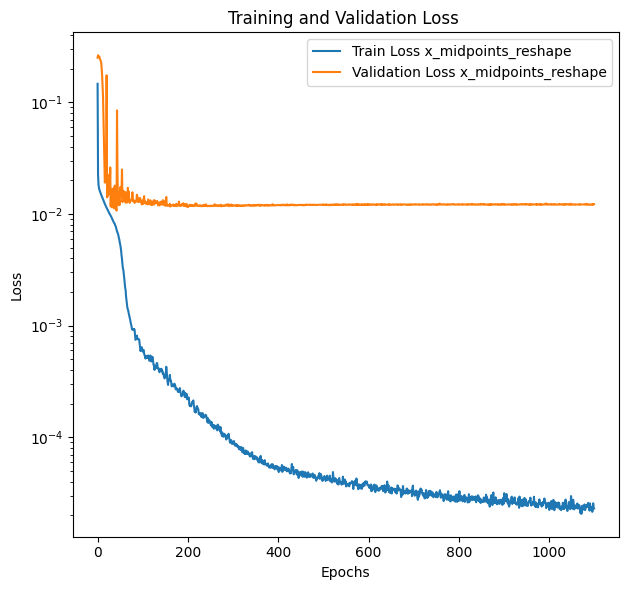

In [14]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
model_builder.model.save("/home/da886/Analysis/30KNoNoiseFixed_index84_13_overfit.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Weights from Josh's model/Josh's5fixedCustomRegularized.keras",
# )

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
    """
    Visualizes midpoints on an image without using a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    midpoints_np = midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title(title)

    # Plot midpoints directly, only if they are not (0, 0)
    for i, (x, y) in enumerate(midpoints_np):
        if x >= 3 and y >= 3:  # Only plot if the point is not (0, 0)
            plt.scatter(x, y, color='red', s=5)

    plt.show()

# Create the validation dataset
# val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# val_dataset = val_dataset.batch(800)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)
# # Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# # Loop through each batch in the validation dataset, predict, and collect results
# for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 64, 64)


2024-10-09 15:33:49.395121: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1728488029.533252 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.533948 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.534290 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.534641 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.534954 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.535281 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488029.535592 1288941 gpu_timer

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1728488030.523135 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.523753 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.524371 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.525021 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.525678 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.526355 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.527034 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.527707 1288941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728488030.528459 1288941 gp

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing batch 2, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 3, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 4, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 5, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 
Processing batch 6, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 7, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 8, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 9, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 10, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 11, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing batch 12, batch shape: (800, 64, 64)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Processing 

In [15]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


In [15]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((24000, 64, 64), (24000, 1, 5, 2), (24000, 1, 5, 2))

In [18]:
# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, midpoints):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Predicted Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# def visualize_midpoints2(image, midpoints):
#     """
#     Visualizes ground truth midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).

#     Returns:
#     None (displays the image with midpoints).
#     """
    
#     image_np = image
#     midpoints_np = midpoints
#     denormalized_image = image_np 

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Ground Truth Midpoint Visualization")

#     # Plot midpoints directly
#     for i, (x, y) in enumerate(midpoints_np):
#         plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Example usage with random data
# t = np.random.randint(0, 800)
# # t=100

# visualize_midpoints(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(outputs[t,0,:,:])*64)
# visualize_midpoints2(tf.convert_to_tensor(inputs[t]), tf.convert_to_tensor(targets[t,0,:,:])*64)


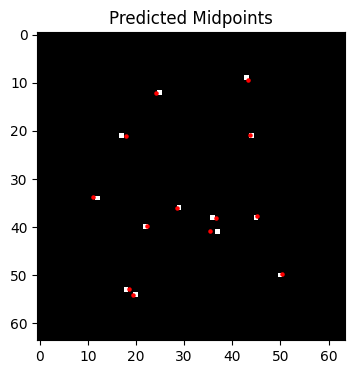

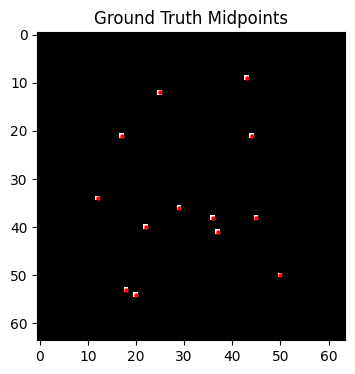

In [34]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * 64, title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * 64, title="Ground Truth Midpoints")


In [44]:
validation_loss = val_images[2]
validation_loss.shape

(64, 64)

In [47]:
loaded_model.evaluate(validation_loss)

ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("IteratorGetNext:0", shape=(32, 64), dtype=float32). Expected shape (None, 64, 64, 1), but input has incompatible shape (32, 64)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 64), dtype=float32)
  • training=False
  • mask=None

In [49]:
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

In [18]:
dynamic_exponent_callback = DynamicExponentCallback(1, 1, 50)
loss_fn = dynamic_exponent_callback.custom_loss(exponent=2)



y_true = train_midpoints # Ground truth
y_pred = all_pred_midpoints  # Predictions


computed_loss = loss_fn(y_true, y_pred)

print(f"Computed loss: {computed_loss.numpy()}")

Computed loss: 0.0044106729328632355


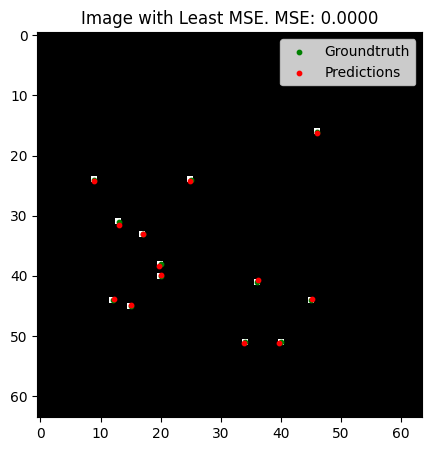

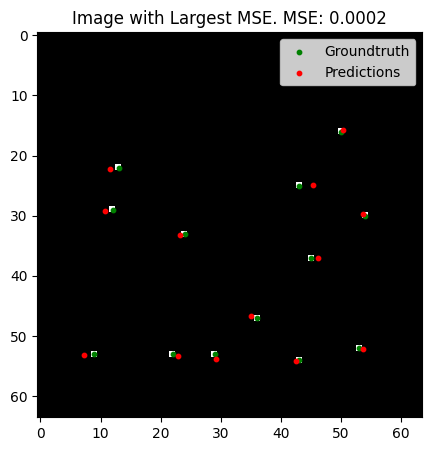

: 

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * 64,  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [263]:
max_mse_index

11548